In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, average_precision_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
!python --version

Python 3.11.11


In [3]:
pip install -U scikit-learn==1.2.2

Note: you may need to restart the kernel to use updated packages.


In [4]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')  
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
X = df.drop('Class', axis=1)
y = df['Class']

In [6]:
print(y)

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64


In [7]:
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
def undersample(X, y):
    fraud_indices = y[y == 1].index
    normal_indices = y[y == 0].index
    n_fraud = len(fraud_indices)
    normal_sample_indices = np.random.choice(normal_indices, n_fraud, replace=False)
    undersample_indices = np.concatenate([fraud_indices, normal_sample_indices])
    return X.loc[undersample_indices], y.loc[undersample_indices]

X_train_us, y_train_us = undersample(X_train, y_train)


Class distribution after undersampling:
Class
1    394
0    394
Name: count, dtype: int64


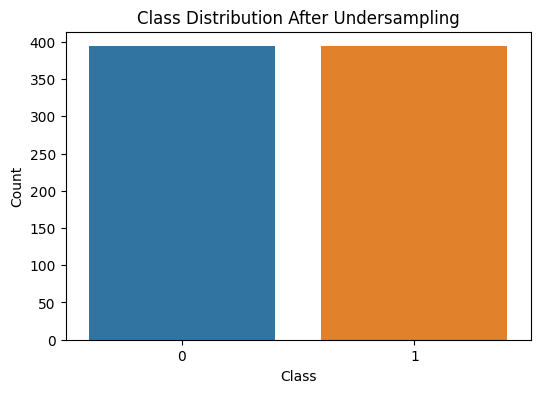


Sample of undersampled features:
            Time         V1        V2         V3        V4         V5  \
42887  -1.127207 -12.835760  6.574615 -12.788462  8.786257 -10.723121   
6338   -1.837575   0.316459  3.809076  -5.615159  6.047445   1.554026   
88897  -0.683811  -5.267760  2.506719  -5.290925  4.886134  -3.343188   
74794  -0.822393  -6.003422 -3.930731  -0.007045  1.714669   3.414667   
107067 -0.516843  -1.512516  1.133139  -1.601052  2.813401  -2.664503   

              V6         V7        V8        V9  ...       V20       V21  \
42887  -2.813536 -14.248847  7.960521 -7.718751  ... -0.617296  2.679490   
6338   -2.651353  -0.746579  0.055586 -2.678679  ...  0.388307  0.208828   
88897  -1.100085  -5.810509  1.726343 -0.749277  ... -0.286043  0.764266   
74794  -2.329583  -1.901512 -2.746111  0.887673  ... -4.128186  1.101671   
107067 -0.310371  -1.520895  0.852996 -1.496495  ...  1.249586  0.729828   

             V22       V23       V24       V25       V26       V27    

In [10]:
print("Class distribution after undersampling:")
print(y_train_us.value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x=y_train_us)
plt.title('Class Distribution After Undersampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

print("\nSample of undersampled features:")
print(X_train_us.head())

print("\nSample of undersampled target:")
print(y_train_us.head())

In [11]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

In [12]:
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 5]
    }
}

In [13]:
best_models = {}
results = []

for name, model in models.items():
    print(f"Training and tuning {name} with undersampled data...")
    grid = GridSearchCV(model, param_grids[name], scoring='average_precision', cv=3, n_jobs=-1)
    grid.fit(X_train_us, y_train_us)
    best_model = grid.best_estimator_
    best_models[name] = best_model

    y_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = best_model.predict(X_test)

    results.append({
        'Model': name,
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'AUPRC': average_precision_score(y_test, y_proba),
        'F1 Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred)
    })

Training and tuning Random Forest with undersampled data...
Training and tuning Decision Tree with undersampled data...
Training and tuning Gradient Boosting with undersampled data...


In [14]:
results_df = pd.DataFrame(results)
print("\nPerformance Comparison (Undersampling):")
print(results_df)


Performance Comparison (Undersampling):
               Model   ROC-AUC     AUPRC  F1 Score  Precision    Recall
0      Random Forest  0.975339  0.721823  0.106825   0.056711  0.918367
1      Decision Tree  0.928108  0.015701  0.030728   0.015622  0.928571
2  Gradient Boosting  0.980300  0.472157  0.065847   0.034134  0.928571


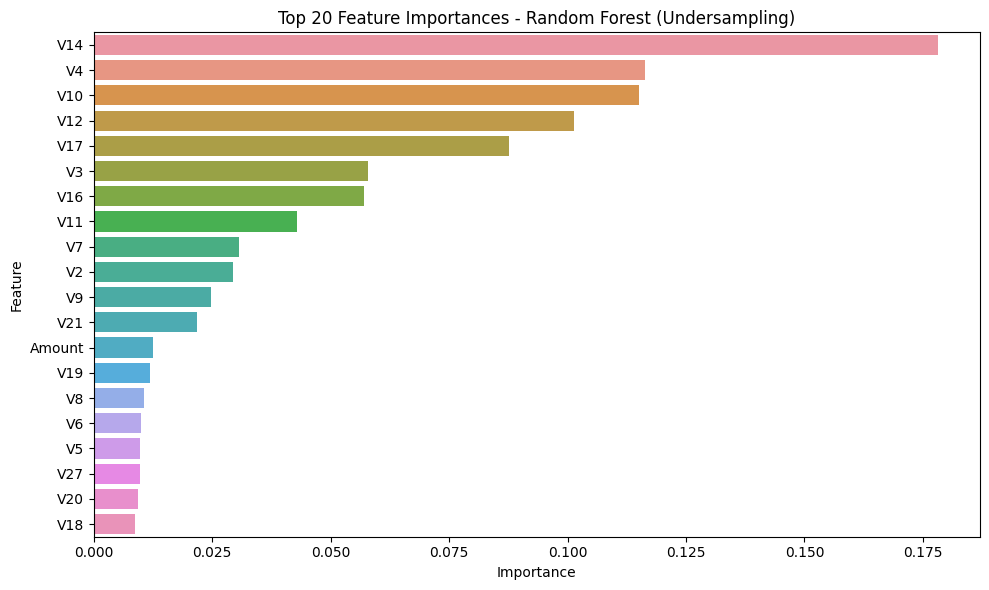

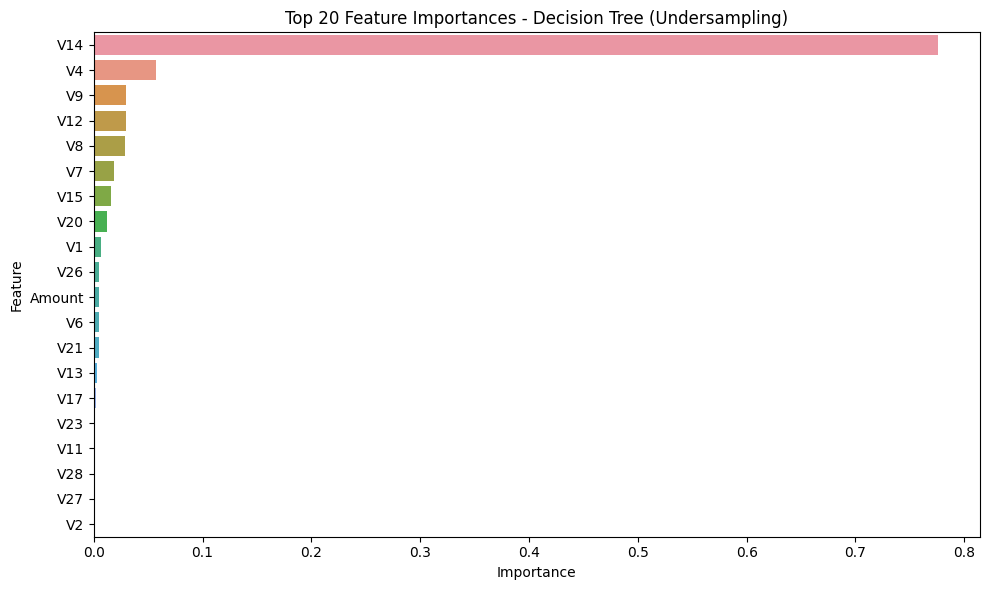

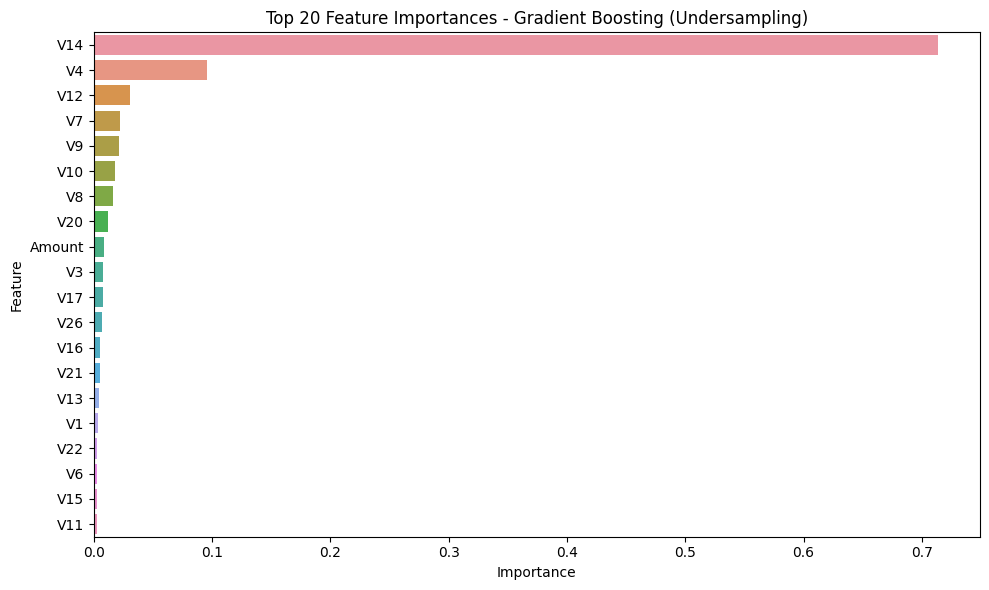

In [15]:
for name, model in best_models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(20)
        plt.figure(figsize=(10,6))
        sns.barplot(x=feat_imp.values, y=feat_imp.index)
        plt.title(f'Top 20 Feature Importances - {name} (Undersampling)')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

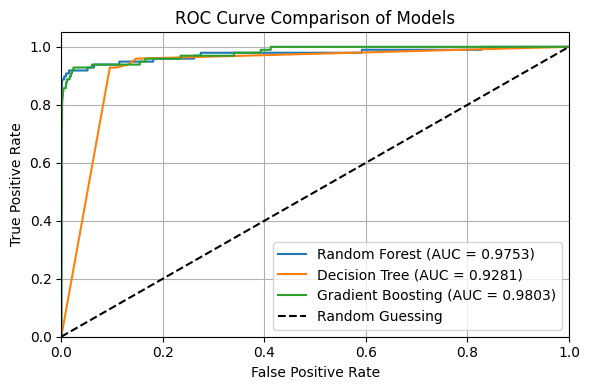

In [16]:

plt.figure(figsize=(6, 4))
for name, model in best_models.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
import joblib
joblib.dump(best_models['Random Forest'], 'fraud_rf_model.pkl')

['fraud_rf_model.pkl']

In [18]:
from kaggle_secrets import UserSecretsClient
from IPython.display import FileLink

FileLink(r'fraud_rf_model.pkl')


/kaggle/working/fraud_rf_model.pkl

In [19]:
import sklearn
print(sklearn.__version__)

1.2.2
